# Experiment to create a model to analyze sentiment for toxicity

![Laungauge Sentiment](launguage-sentiment.gif)

### This experiment tries to create a model with high level of efficiency in predicting toxicity of text. It uses the Wiki detox dataset that has been manually scored for toxicity to identify how to score for toxicity. We are trying out various algorithms to see which fits the problem space better. The experiment is performed using ML.net over the below set of steps.

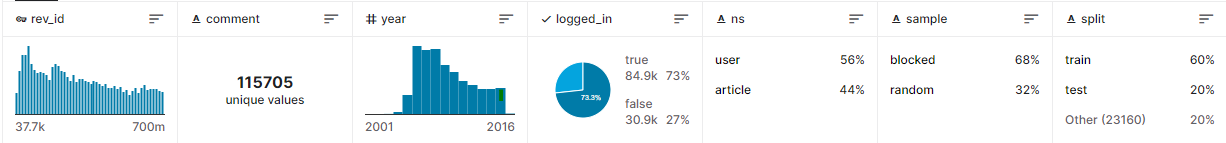

### Install the necessary nuget packages. 

In [1]:
#r "nuget:Microsoft.ML, 2.0.1"
#r "nuget:Microsoft.Data.Analysis, 0.20.1"
#r "nuget:XPlot.Plotly.Interactive, 4.0.6"
#r "nuget:XPlot.Plotly, 4.0.6"

Installed Packages Microsoft.Data.Analysis, 0.20.1 Microsoft.ML, 2.0.1 XPlot.Plotly, 4.0.6 XPlot.Plotly.Interactive, 4.0.6

Loading extensions from `/home/pradeepl/.nuget/packages/microsoft.data.analysis/0.20.1/interactive-extensions/dotnet/Microsoft.Data.Analysis.Interactive.dll`

Loading extensions from `/home/pradeepl/.nuget/packages/xplot.plotly.interactive/4.0.6/interactive-extensions/dotnet/XPlot.Plotly.Interactive.dll`

Configuring PowerShell Kernel for XPlot.Plotly integration.

Installed support for XPlot.Plotly.

### Adding the necessary namespaces

In [2]:
using System;
using System.IO;
using Microsoft.ML;
using static Microsoft.ML.DataOperationsCatalog;
using Microsoft.ML.Trainers;
using Microsoft.Data.Analysis;
using System.Linq;
using XPlot.Plotly;

### Load the data for training using the WikiDetox training dataset which is in the below github repo

In [3]:
using System.IO;
using System.Net.Http;
string wikiDetoxPath = "wikiDetoxAnnotated40kRows.tsv";

if (!File.Exists(wikiDetoxPath))
{
    var contents = await new HttpClient()
        .GetStringAsync("https://raw.githubusercontent.com/PradeepLoganathan/SentimentAnalysisTrainer/main/SentimentAnalysisTrainer/Data/wikiDetoxAnnotated40kRows.tsv");
        
    File.WriteAllText(wikiDetoxPath, contents);
}

### Define the data structure in the training dataset

In [4]:
using Microsoft.ML.Data;

public class SentimentIssue
{
    [LoadColumn(0)]
    public bool Label { get; set; }
    [LoadColumn(2)]
    public string Text { get; set; }
}

### Create a dataview from the loaded data.

In [6]:
var mlContext = new MLContext(seed: 1);
IDataView dataView = mlContext.Data.LoadFromTextFile<SentimentIssue>(wikiDetoxPath, hasHeader: true);

### Display the sample data 

In [7]:
dataView.Schema.Display();
dataView.Preview().RowView.Display();

index value 0 Label: Boolean Name Label Index 0 IsHidden False Type Boolean RawType System.Boolean Annotations Schema (empty) 1 Text: String Name Text Index 1 IsHidden False Type String RawType System.ReadOnlyMemory<System.Char> Annotations Schema (empty)

index value 0 2 columns Values index value 0 [Label, False] Key Label Value False 1 [Text, " ==He is a Rapist!!!!!== Please edit the article to include this important fact. Thank You. — Preceding unsigned comment added by • "] Key Text Value " ==He is a Rapist!!!!!== Please edit the article to include this important fact. Thank You. — Preceding unsigned comment added by • " 1 2 columns Values index value 0 [Label, False] Key Label Value False 1 [Text, The other two films Hitch and Magnolia are also directly related to the community in question, and may be of interest to those who see those films. So why not link to them? ] Key Text Value The other two films Hitch and Magnolia are also directly related to the community in question, and may be of interest to those who see those films. So why not link to them? 2 2 columns Values index value 0 [Label, False] Key Label Value False 1 [Text, == blocking people == how can i block lambs12 from my page and editing my stuff she's saying bad things she's my sister ] Key Text Value == blocking people == how can i block lambs12 from my page and editing my stuff she's saying bad things she's my sister 3 2 columns Values index value 0 [Label, True] Key Label Value True 1 [Text, == Are you a female????? == mootmootmootmootmootmootmootmootmootmoot] Key Text Value == Are you a female????? == mootmootmootmootmootmootmootmootmootmoot 4 2 columns Values index value 0 [Label, False] Key Label Value False 1 [Text, :::::Good enough for me; thanks for the info. I'll check the Sheffield references later. - ] Key Text Value :::::Good enough for me; thanks for the info. I'll check the Sheffield references later. - 5 2 columns Values index value 0 [Label, False] Key Label Value False 1 [Text, == Motherjane concert location == Hi, Motherjane, being a popular band, has headlined a lot of college rock festivals in India. But quoting the name of every college that they have performed is not quite right. So please refrain from adding the names of any more colleges/institutes. Thanks!... Key Text Value == Motherjane concert location == Hi, Motherjane, being a popular band, has headlined a lot of college rock festivals in India. But quoting the name of every college that they have performed is not quite right. So please refrain from adding the names of any more colleges/institutes. Thanks! — 6 2 columns Values index value 0 [Label, False] Key Label Value False 1 [Text, == warning == don't vandalize ] Key Text Value == warning == don't vandalize 7 2 columns Values index value 0 [Label, False] Key Label Value False 1 [Text, " :There were reviews from critics in her song? "] Key Text Value " :There were reviews from critics in her song? " 8 2 columns Values index value 0 [Label, False] Key Label Value False 1 [Text, " Jack, is it a misrepresentation for you to write more than 500,000 nucleotide base pairs, or should you write 582 base pair. Lets start watching ""RNA world"" page too. "] Key Text Value " Jack, is it a misrepresentation for you to write more than 500,000 nucleotide base pairs, or should you write 582 base pair. Lets start watching ""RNA world"" page too. " 9 2 columns Values index value 0 [Label, False] Key Label Value False 1 [Text, ":Thank you, I will use these tool responsibly. (Editor Review) "] Key Text Value ":Thank you, I will use these tool responsibly. (Editor Review) " 10 2 columns Values index value 0 [Label, False] Key Label Value False 1 [Text, HELLO SITUSH ARE YOU THERE?? PEOPLE HAVE SOME QUESTIONS] Key Text Value HELLO SITUSH ARE YOU THERE?? PEOPLE HAVE SOME QUESTIONS 11 2 columns Values index value 0 [Label, False] Key Label Value False 1 [Text, -FREE MYANMAR!!! STOP THE MILITARY REGIME!!!! PATS1 DOESN't CARE!!! HE ONLY CARES ABOUT FOOTBALL AND ORDER!!!!!!!!!!!!!!!!] Key Text Value -FREE MYANMAR!!! STOP THE MILITARY REGIME!!!! PATS1 DOESN't CARE!!! HE ONLY CARES ABOUT FOOTBALL AND ORDER!!!!!!!!!!!!!!!! 12 2 columns Values index value 0 [Label, False] Key Label Value False 1 [Text, " :M

### Plotting the sample data

In [8]:
Chart.Plot(
    new Histogram()
    {
        x = dataView.GetColumn<bool>("Label"),
        nbinsx = 20
    }
)

<!DOCTYPE html>

### Split the data into training data and testing data. I am choosing a 80:20 split.

In [9]:
TrainTestData trainTestSplit = mlContext.Data.TrainTestSplit(dataView, testFraction: 0.2);
IDataView trainingData = trainTestSplit.TrainSet;
IDataView testData = trainTestSplit.TestSet;

### We now need to transform the text to be used by the algorithm.

Transformers take data, do some work on it, and return new, transformed data. For example, did you know that you can only feed numbers to the engine? This is how a text is being transformed as an example FeaturizeText("This is a text we want to use") => [0.86, 0.67, 0.45, 0.99....]

In [10]:
var dataProcessPipeline = mlContext.Transforms.Text.FeaturizeText(outputColumnName: "Features", inputColumnName: nameof(SentimentIssue.Text));

### This is a classic binary classification problem where we need to classify text into toxic or non-toxic sentiment. There are various binary classification algorithms that can be used to train the model as below. Let us try and see which binary classification algorithm works best based on the data fit.

##### using SDCA Logistic Regression algorithm

In [11]:
var trainer = mlContext.BinaryClassification.Trainers.SdcaLogisticRegression(labelColumnName: "Label", featureColumnName: "Features");

##### using SGD Calibrated algorithm

In [52]:
var trainer = mlContext.BinaryClassification.Trainers.SgdCalibrated(labelColumnName: "Label", featureColumnName: "Features");

#### using LBFGS logistic regression algorithm

In [54]:
var trainer = mlContext.BinaryClassification.Trainers.LbfgsLogisticRegression(labelColumnName: "Label", featureColumnName: "Features");

#### using Averaged Perceptron algorithm

In [ ]:
var trainer = mlContext.BinaryClassification.Trainers.AveragedPerceptron(labelColumnName: "Label", featureColumnName: "Features");

### Creating the training pipeline and adding the trainer

In [12]:
 var trainingPipeline = dataProcessPipeline.Append(trainer);

In [13]:
ITransformer trainedModel = trainingPipeline.Fit(trainingData);

### Evaluate the model

In [14]:
var predictions = trainedModel.Transform(testData);
var metrics = mlContext.BinaryClassification.Evaluate(data: predictions, labelColumnName: "Label", scoreColumnName: "Score");
display(metrics);

LogLoss,0.217010439653296
LogLossReduction,0.5178105633558839
Entropy,0.4500522474395522
AreaUnderRocCurve,0.9397950874940268
Accuracy,0.9466316710411199
PositivePrecision,0.9158163265306123
PositiveRecall,0.4767596281540505
NegativePrecision,0.9482192140885793
NegativeRecall,0.9954470198675497
F1Score,0.6270742358078603
AreaUnderPrecisionRecallCurve,0.770933565916623


### Create prediction engine related to the loaded trained model

In [20]:
public class SentimentIssue
{
    [LoadColumn(0)]
    public bool Label { get; set; }
    [LoadColumn(2)]
    public string Text { get; set; }
}

public class SentimentPrediction
{

    [ColumnName("PredictedLabel")]
    public bool Prediction { get; set; }
    public float Probability { get; set; }
    public float Score { get; set; }
}

#### Test the model with a simple use case

In [30]:
SentimentIssue sampleStatement = new SentimentIssue { Text = "THis is stupid" };
var predEngine = mlContext.Model.CreatePredictionEngine<SentimentIssue, SentimentPrediction>(trainedModel);
var resultprediction = predEngine.Predict(sampleStatement);
Console.WriteLine($"=============== Single Prediction  ===============");
Console.WriteLine($"Text: {sampleStatement.Text} | Prediction: {(Convert.ToBoolean(resultprediction.Prediction) ? "Toxic" : "Non Toxic")} sentiment | Probability of being toxic: {resultprediction.Probability} ");
Console.WriteLine($"================End of Process.Hit any key to exit==================================");

=============== Single Prediction  ===============
Text: THis is stupid | Prediction: Toxic sentiment | Probability of being toxic: 0.9705522 
================End of Process.Hit any key to exit==================================


#### Plot the variance in predictions vs score

In [16]:
using XPlot.Plotly;

int totalNumberForBarChart = 200;
predictions.Schema.Display();
predictions.Preview().RowView.Display();

var ActualValuesGroupBarGraph = new XPlot.Plotly.Bar()
{
   x = elements,
   y = actual,
   name = "Actual"
};

bool[] actual = predictions.GetColumn<bool>("Label").Take(totalNumberForBarChart).ToArray();
bool[] prediction = predictions.GetColumn<bool>("PredictedLabel").Take(totalNumberForBarChart).ToArray();
int[] elements = Enumerable.Range(0, totalNumberForBarChart).ToArray();

// Define group for Prediction values
var PredictionValuesGroupBarGraph = new XPlot.Plotly.Bar()
{
   x = elements,
   y = prediction,
   name = "Predicted"
};

var chart = Chart.Plot(new[] {ActualValuesGroupBarGraph, PredictionValuesGroupBarGraph});
var layout = new Layout.Layout(){barmode = "group", title="Actual sentiment vs. Predicted sentiment Comparison"};
chart.WithLayout(layout);
chart.WithXTitle("Cases");
chart.WithYTitle("Sentiment");
chart.WithLegend(true);
chart.Width = 700;
chart.Height = 400;

display(chart);

index value 0 Label: Boolean Name Label Index 0 IsHidden False Type Boolean RawType System.Boolean Annotations Schema (empty) 1 Text: String Name Text Index 1 IsHidden False Type String RawType System.ReadOnlyMemory<System.Char> Annotations Schema (empty) 2 Features: Vector {IsNormalized, SlotNames} Name Features Index 2 IsHidden False Type Vector Dimensions [ 1017430 ] IsKnownSize True ItemType Single RawType System.Single Size 1017430 RawType Microsoft.ML.Data.VBuffer<System.Single> Annotations IsNormalized, SlotNames Schema index value 0 IsNormalized: Boolean Name IsNormalized Index 0 IsHidden False Type Boolean RawType System.Boolean Annotations Schema [ ] 1 SlotNames: Vector Name SlotNames Index 1 IsHidden False Type Vector Dimensions [ 1017430 ] IsKnownSize True ItemType String Size 1017430 RawType Microsoft.ML.Data.VBuffer`1[System.ReadOnlyMemory`1[System.Char]] Annotations Schema [ ] 3 PredictedLabel: Boolean {ScoreColumnKind, ScoreValueKind, ScoreColumnSetId} Name PredictedLabel Index 3 IsHidden False Type Boolean RawType System.Boolean Annotations ScoreColumnKind, ScoreValueKind, ScoreColumnSetId Schema index value 0 ScoreColumnKind: String Name ScoreColumnKind Index 0 IsHidden False Type String RawType System.ReadOnlyMemory`1[System.Char] Annotations Schema [ ] 1 ScoreValueKind: String Name ScoreValueKind Index 1 IsHidden False Type String RawType System.ReadOnlyMemory`1[System.Char] Annotations Schema [ ] 2 ScoreColumnSetId: Key Name ScoreColumnSetId Index 2 IsHidden False Type Key Count 2147483647 RawType System.UInt32 Annotations Schema [ ] 4 Score: Single {ScoreColumnKind, ScoreColumnSetId, ScoreValueKind} Name Score Index 4 IsHidden False Type Single RawType System.Single Annotations ScoreColumnKind, ScoreColumnSetId, ScoreValueKind Schema index value 0 ScoreColumnKind: String Name ScoreColumnKind Index 0 IsHidden False Type String RawType System.ReadOnlyMemory`1[System.Char] Annotations Schema [ ] 1 ScoreColumnSetId: Key Name ScoreColumnSetId Index 1 IsHidden False Type Key Count 2147483647 RawType System.UInt32 Annotations Schema [ ] 2 ScoreValueKind: String Name ScoreValueKind Index 2 IsHidden False Type String RawType System.ReadOnlyMemory`1[System.Char] Annotations Schema [ ] 5 Probability: Single {ScoreColumnKind, ScoreColumnSetId, IsNormalized, ScoreValueKind} Name Probability Index 5 IsHidden False Type Single RawType System.Single Annotations ScoreColumnKind, ScoreColumnSetId, IsNormalized, ScoreValueKind Schema index value 0 ScoreColumnKind: String Name ScoreColumnKind Index 0 IsHidden False Type String RawType System.ReadOnlyMemory`1[System.Char] Annotations Schema [ ] 1 ScoreColumnSetId: Key Name ScoreColumnSetId Index 1 IsHidden False Type Key Count 2147483647 RawType System.UInt32 Annotations Schema [ ] 2 IsNormalized: Boolean Name IsNormalized Index 2 IsHidden False Type Boolean RawType System.Boolean Annotations Schema [ ] 3 ScoreValueKind: String Name ScoreValueKind Index 3 IsHidden False Type String RawType System.ReadOnlyMemory`1[System.Char] Annotations Schema [ ]

index value 0 6 columns Values index value 0 [Label, False] Key Label Value False 1 [Text, == blocking people == how can i block lambs12 from my page and editing my stuff she's saying bad things she's my sister ] Key Text Value == blocking people == how can i block lambs12 from my page and editing my stuff she's saying bad things she's my sister 2 [Features, Sparse vector of size 1017430, 134 explicit values] Key Features Value Sparse vector of size 1017430, 134 explicit values IsDense False Length 1017430 3 [PredictedLabel, False] Key PredictedLabel Value False 4 [Score, -1.0107062] Key Score Value -1.0107062 5 [Probability, 0.26684168] Key Probability Value 0.26684168 1 6 columns Values index value 0 [Label, False] Key Label Value False 1 [Text, " :Michael, with all due respect, it's over. It may be that you can do math better than me, but it's not the math that's the problem, it's statements like ""I don't know a whole lot about this case, but I tend to think that race may well be relevant here"" and ""My first instinct is it likely... Key Text Value " :Michael, with all due respect, it's over. It may be that you can do math better than me, but it's not the math that's the problem, it's statements like ""I don't know a whole lot about this case, but I tend to think that race may well be relevant here"" and ""My first instinct is it likely should be included as the news accounts likely included the information. But did they or was this simply not an issue?"". I assume you are ""counting"" those as ""in favour of inclusion""really, one can't. They are not unequivocal inclusion votes and raise more questions than they answer. Moreover, I assume you're including comments like ""I agree that race should be included as long as it does not violate WP:UNDUE."" That's finebut this participant did not address how the inclusion does not violate UNDUE, and since this (as John points out) is not a vote, such a statement can't have the full weight as is carried by the more complete answers of John and Beyond My Ken. " 2 [Features, Sparse vector of size 1017430, 753 explicit values] Key Features Value Sparse vector of size 1017430, 753 explicit values IsDense False Length 1017430 3 [PredictedLabel, False] Key PredictedLabel Value False 4 [Score, -3.4855075] Key Score Value -3.4855075 5 [Probability, 0.02972741] Key Probability Value 0.02972741 2 6 columns Values index value 0 [Label, False] Key Label Value False 1 [Text, == Ecotheology is a acceptet term == I strongly suggest that the headline is keept. Just check out the web, ecotheology is a well known and accepted term. Religion and economy can be a link or further reading. ] Key Text Value == Ecotheology is a acceptet term == I strongly suggest that the headline is keept. Just check out the web, ecotheology is a well known and accepted term. Religion and economy can be a link or further reading. 2 [Features, Sparse vector of size 1017430, 210 explicit values] Key Features Value Sparse vector of size 1017430, 210 explicit values IsDense False Length 1017430 3 [PredictedLabel, False] Key PredictedLabel Value False 4 [Score, -1.8054379] Key Score Value -1.8054379 5 [Probability, 0.1411904] Key Probability Value 0.1411904 3 6 columns Values index value 0 [Label, False] Key Label Value False 1 [Text, Welcome Hello and welcome to Wikipedia. We appreciate encyclopedic contributions, but some of your recent contributions seem to be advertising or for promotional purposes. Wikipedia does not allow advertising in articles. For more information on this, see *Policy on neutral point of view ... Key Text Value Welcome Hello and welcome to Wikipedia. We appreciate encyclopedic contributions, but some of your recent contributions seem to be advertising or for promotional purposes. Wikipedia does not allow advertising in articles. For more information on this, see *Policy on neutral point of view *Guideline on spam *Guideline on external links *Guideline on conflict of interest If you still have ques

<!DOCTYPE html>